# HoneyBee Radiology Components - Comprehensive Testing and Visualization

This notebook demonstrates all the consolidated radiology components using real CT DICOM samples.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lab-rasool/HoneyBee/blob/main/examples/mayo/02_radiology_preprocessing.ipynb)

## 📋 Colab Requirements and Setup

**For Google Colab Users:**
- **Runtime**: GPU recommended (T4 or better) for faster model inference
- **RAM**: High-RAM runtime recommended for loading DICOM volumes
- **Storage**: ~100MB for sample data and models
- **Time**: Initial setup takes ~3-5 minutes

**What this notebook does:**
1. Demonstrates radiology image preprocessing with real CT DICOM samples
2. Shows various preprocessing techniques (windowing, denoising, normalization)
3. Performs lung segmentation
4. Generates RadImageNet embeddings for medical images

**Note**: This notebook uses a minimal CT dataset suitable for Colab's resource limitations.

In [ ]:
# Setup cell - Configure Python path and environment
import sys
from pathlib import Path

# Add the parent directory to Python path to import honeybee
honeybee_root = Path().absolute().parent.parent
sys.path.insert(0, str(honeybee_root))
print(f"Added to Python path: {honeybee_root}")

# Check if we're in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
    
    !apt-get update && apt-get install -y openslide-tools tesseract-ocr

    # Setup Colab-specific paths
    MODEL_DIR = Path("/content/models")
    MODEL_DIR.mkdir(exist_ok=True)
    
    # Clone repo if not already done
    if not Path("/content/HoneyBee").exists():
        print("📥 Cloning HoneyBee repository...")
        !git clone https://github.com/lab-rasool/HoneyBee.git /content/HoneyBee
        # Add cloned repo to path
        sys.path.insert(0, "/content/HoneyBee")
    else:
        sys.path.insert(0, "/content/HoneyBee")

    # Install Python dependencies
    !curl -LsSf https://astral.sh/uv/install.sh | sh
    !uv pip install -r /content/HoneyBee/requirements.txt
        
except ImportError:
    IN_COLAB = False
    print("💻 Running locally")
    MODEL_DIR = Path.home() / "Models" / "radimagenet"
    
print(f"Model directory: {MODEL_DIR}")

# Import torch early as it's used later
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Added to Python path: /mnt/f/Projects/HoneyBee
💻 Running locally
Model directory: /home/aakash/Models/radimagenet
PyTorch version: 2.7.0+cu126
CUDA available: True


In [4]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# HoneyBee imports (path already added in setup cell)
from honeybee.loaders.Radiology import (
    DicomLoader, 
    NiftiLoader, 
    RadiologyDataset, 
    ImageMetadata, 
    load_medical_image, 
    load_dicom_series
)

from honeybee.processors.radiology import (
    RadiologyProcessor,
    Denoiser, 
    IntensityNormalizer, 
    WindowLevelAdjuster, 
    ArtifactReducer,
    preprocess_ct, 
    preprocess_mri, 
    preprocess_pet
)

from honeybee.models.RadImageNet import RadImageNet

print("✓ Imports successful")

✓ Imports successful


In [5]:
# Sample Data Setup for Colab
if IN_COLAB:
    import shutil
    from pathlib import Path
    
    # Define sample data paths
    sample_ct_path = Path("/content/sample_data/CT")
    sample_ct_path.mkdir(parents=True, exist_ok=True)
    
    # Option 1: Use minimal built-in sample (2-3 DICOM files)
    print("📁 Setting up minimal CT sample data...")
    
    # Check if sample data exists in cloned repo
    repo_samples = Path("/content/HoneyBee/examples/samples/CT")
    if repo_samples.exists():
        # Copy only the smallest series
        series_dirs = list(repo_samples.iterdir())
        if series_dirs:
            # Use the smallest series (series 5 with only 2 files)
            smallest_series = "1.3.6.1.4.1.14519.5.2.1.6450.4007.203200234005559533229931362134"
            source_dir = repo_samples / smallest_series
            if source_dir.exists():
                dest_dir = sample_ct_path / smallest_series
                shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)
                print(f"✅ Copied minimal CT series: {smallest_series}")
            else:
                print("⚠️ Sample series not found, will use synthetic data")
    
    # Option 2: Allow users to upload their own DICOM files
    print("\n📤 Option: Upload your own DICOM files")
    print("You can upload DICOM files using the file browser on the left")
    print("or by running the upload cell below.")
    
    # Set the CT samples path for the notebook
    CT_SAMPLES_PATH = sample_ct_path
else:
    # Local path
    CT_SAMPLES_PATH = Path("../samples/CT")
    
print(f"\nCT samples will be loaded from: {CT_SAMPLES_PATH}")


CT samples will be loaded from: ../samples/CT


In [6]:
# Optional: File Upload Cell for Custom DICOM Data (Colab Only)
if IN_COLAB:
    from google.colab import files
    
    print("📤 Upload your own DICOM files (optional)")
    print("Click 'Choose Files' to upload DICOM files:")
    print("Note: For best results, upload 5-10 DICOM slices from the same series")
    
    # Uncomment the lines below to enable file upload
    # uploaded = files.upload()
    # if uploaded:
    #     # Create a custom series directory
    #     custom_series_path = CT_SAMPLES_PATH / "custom_series" / "custom_series"
    #     custom_series_path.mkdir(parents=True, exist_ok=True)
    #     
    #     # Save uploaded files
    #     for filename, content in uploaded.items():
    #         if filename.endswith('.dcm'):
    #             filepath = custom_series_path / filename
    #             with open(filepath, 'wb') as f:
    #                 f.write(content)
    #             print(f"✅ Saved: {filename}")
else:
    print("File upload is only available in Google Colab")

File upload is only available in Google Colab


## 2. Data Loading - DICOM Series

In [26]:
# Define sample data paths
from pathlib import Path

# Set default CT samples path (will be overridden by setup cell if needed)
if 'CT_SAMPLES_PATH' not in globals():
    CT_SAMPLES_PATH = Path("../samples/CT")

# Use the path set in setup
print(f"CT samples directory: {CT_SAMPLES_PATH.absolute()}")

# List available CT series
if CT_SAMPLES_PATH.exists():
    ct_series = [d for d in CT_SAMPLES_PATH.iterdir() if d.is_dir()]
    print(f"\nFound {len(ct_series)} CT series:")

    # Show available series
    for i, series in enumerate(ct_series[:5]):  # Show first 5
        print(f"  {i+1}. {series.name}")
else:
    print(f"\n⚠️ CT samples directory not found at {CT_SAMPLES_PATH}")
    print("Please check the path or run the setup cells.")

CT samples directory: /mnt/f/Projects/HoneyBee/examples/mayo/../samples/CT

Found 8 CT series:
  1. 1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915
  2. 1.3.6.1.4.1.14519.5.2.1.6450.4007.162126622221263740464333395849
  3. 1.3.6.1.4.1.14519.5.2.1.6450.4007.192159949654944985729364816700
  4. 1.3.6.1.4.1.14519.5.2.1.6450.4007.192580272562542828999316939170
  5. 1.3.6.1.4.1.14519.5.2.1.6450.4007.203200234005559533229931362134


In [27]:
# Load a DICOM series
series_path = ct_series[0] / ct_series[0].name  # Get the actual DICOM directory
print(f"Loading series from: {series_path}")

# Method 1: Using DicomLoader
dicom_loader = DicomLoader(lazy_load=False)
volume, metadata = dicom_loader.load_series(series_path)

print(f"\n✓ Loaded volume shape: {volume.shape}")
print(f"  Data type: {volume.dtype}")
print(f"  Value range: [{volume.min():.1f}, {volume.max():.1f}]")

# Display metadata
print("\nMetadata:")
print(f"  Modality: {metadata.modality}")
print(f"  Patient ID: {metadata.patient_id}")
print(f"  Study Date: {metadata.study_date}")
print(f"  Series Description: {metadata.series_description}")
print(f"  Pixel Spacing: {metadata.pixel_spacing}")
print(f"  Number of Slices: {metadata.number_of_slices}")

Loading series from: ../samples/CT/1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915/1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915


INFO:honeybee.loaders.Radiology.loader:Auto-selected series 1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915 with 101 files



✓ Loaded volume shape: (101, 512, 512)
  Data type: float32
  Value range: [-2048.0, 3072.0]

Metadata:
  Modality: CT
  Patient ID: TCGA-61-1740
  Study Date: 19941028
  Series Description: ABD/PELVIS
  Pixel Spacing: (0.976562, 0.976562, 5.0)
  Number of Slices: 101


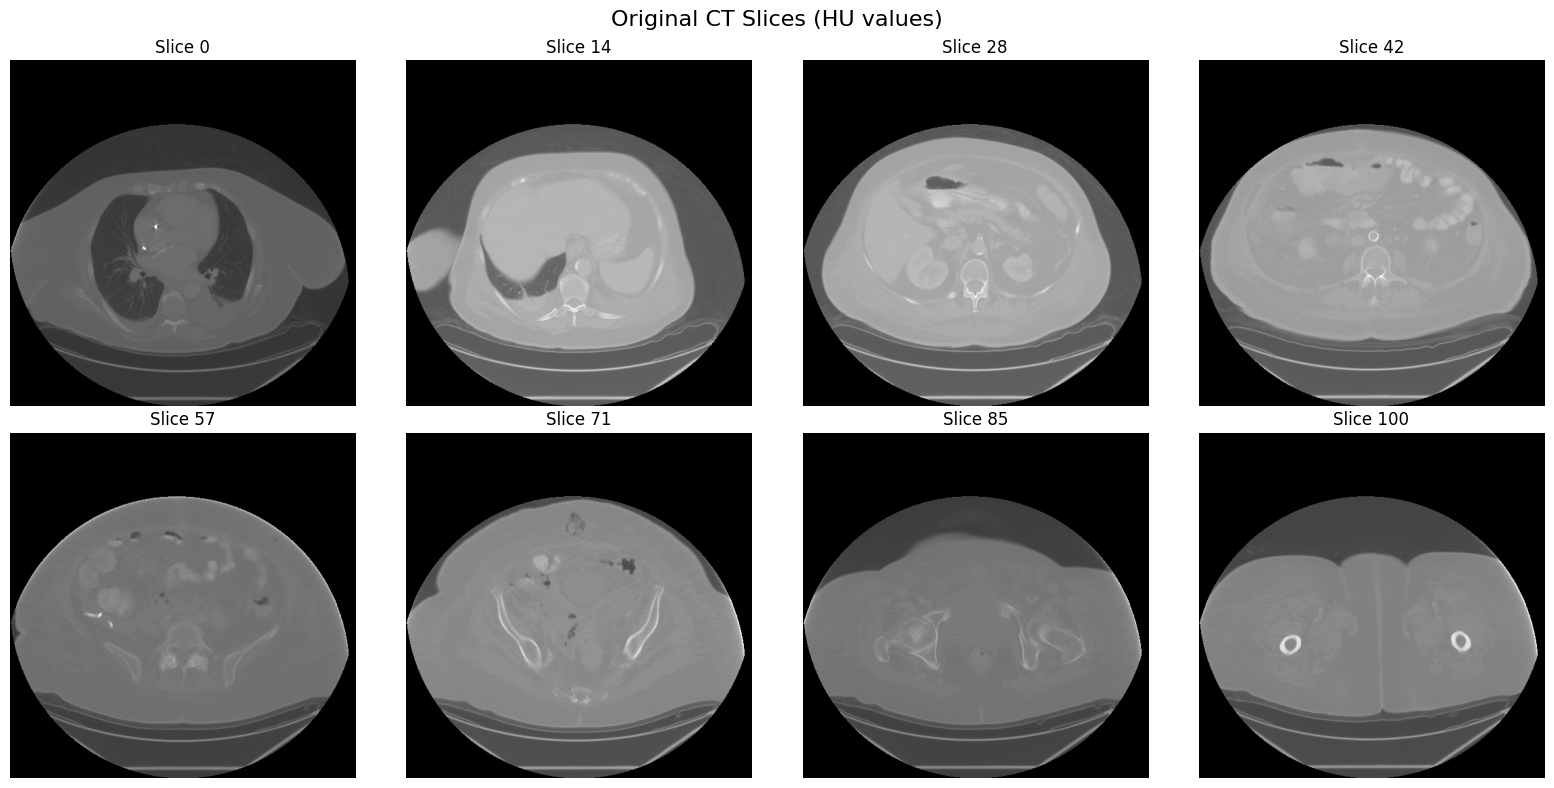

In [28]:
# Visualize some slices
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Select 8 evenly spaced slices
slice_indices = np.linspace(0, volume.shape[0]-1, 8, dtype=int)

for i, idx in enumerate(slice_indices):
    axes[i].imshow(volume[idx], cmap='gray')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.suptitle('Original CT Slices (HU values)', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Preprocessing Components

### 3.1 Window/Level Adjustment

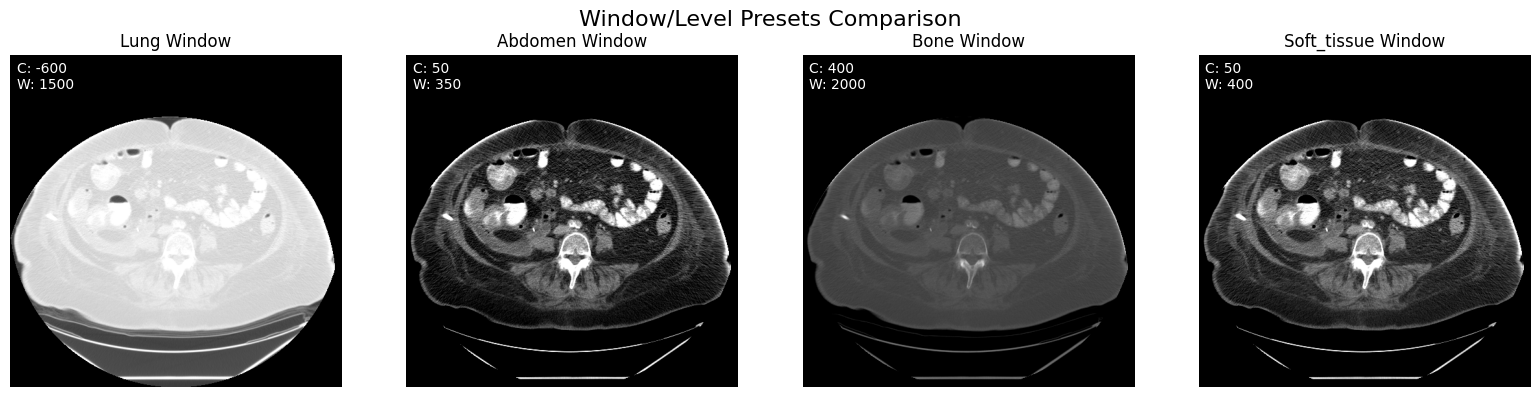

In [29]:
# Test different window presets
windower = WindowLevelAdjuster()
middle_slice = volume[volume.shape[0]//2]

# Apply different window presets
presets = ['lung', 'abdomen', 'bone', 'soft_tissue']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, preset in enumerate(presets):
    windowed = windower.adjust(middle_slice, window=preset)
    axes[i].imshow(windowed, cmap='gray')
    axes[i].set_title(f'{preset.capitalize()} Window')
    axes[i].axis('off')
    
    # Show window settings
    settings = windower.PRESETS[preset]
    axes[i].text(0.02, 0.98, f"C: {settings['center']}\nW: {settings['width']}", 
                transform=axes[i].transAxes, color='white', 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5),
                verticalalignment='top', fontsize=10)

plt.suptitle('Window/Level Presets Comparison', fontsize=16)
plt.tight_layout()
plt.show()

### 3.2 Denoising Methods

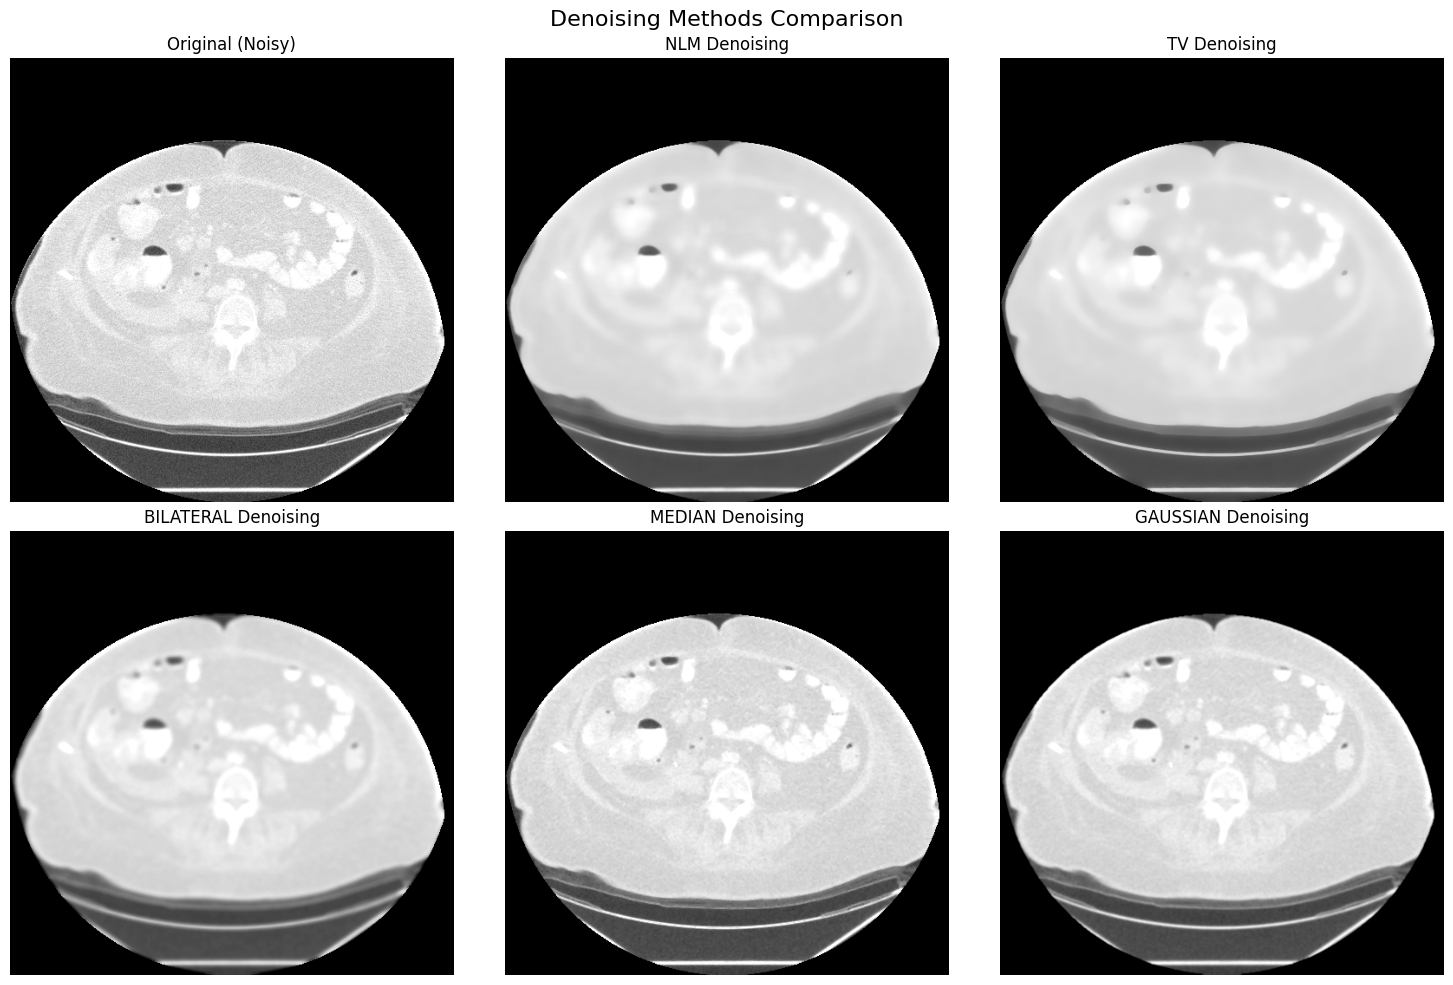

In [30]:
# Add some noise to demonstrate denoising
noisy_slice = middle_slice + np.random.normal(0, 50, middle_slice.shape)

# Test different denoising methods
methods = ['nlm', 'tv', 'bilateral', 'median', 'gaussian']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Original noisy image
windowed_noisy = windower.adjust(noisy_slice, window='lung')
axes[0].imshow(windowed_noisy, cmap='gray')
axes[0].set_title('Original (Noisy)')
axes[0].axis('off')

# Apply different denoising methods
for i, method in enumerate(methods):
    denoiser = Denoiser(method=method)
    denoised = denoiser.denoise(noisy_slice)
    windowed_denoised = windower.adjust(denoised, window='lung')
    
    axes[i+1].imshow(windowed_denoised, cmap='gray')
    axes[i+1].set_title(f'{method.upper()} Denoising')
    axes[i+1].axis('off')

plt.suptitle('Denoising Methods Comparison', fontsize=16)
plt.tight_layout()
plt.show()

### 3.3 Intensity Normalization

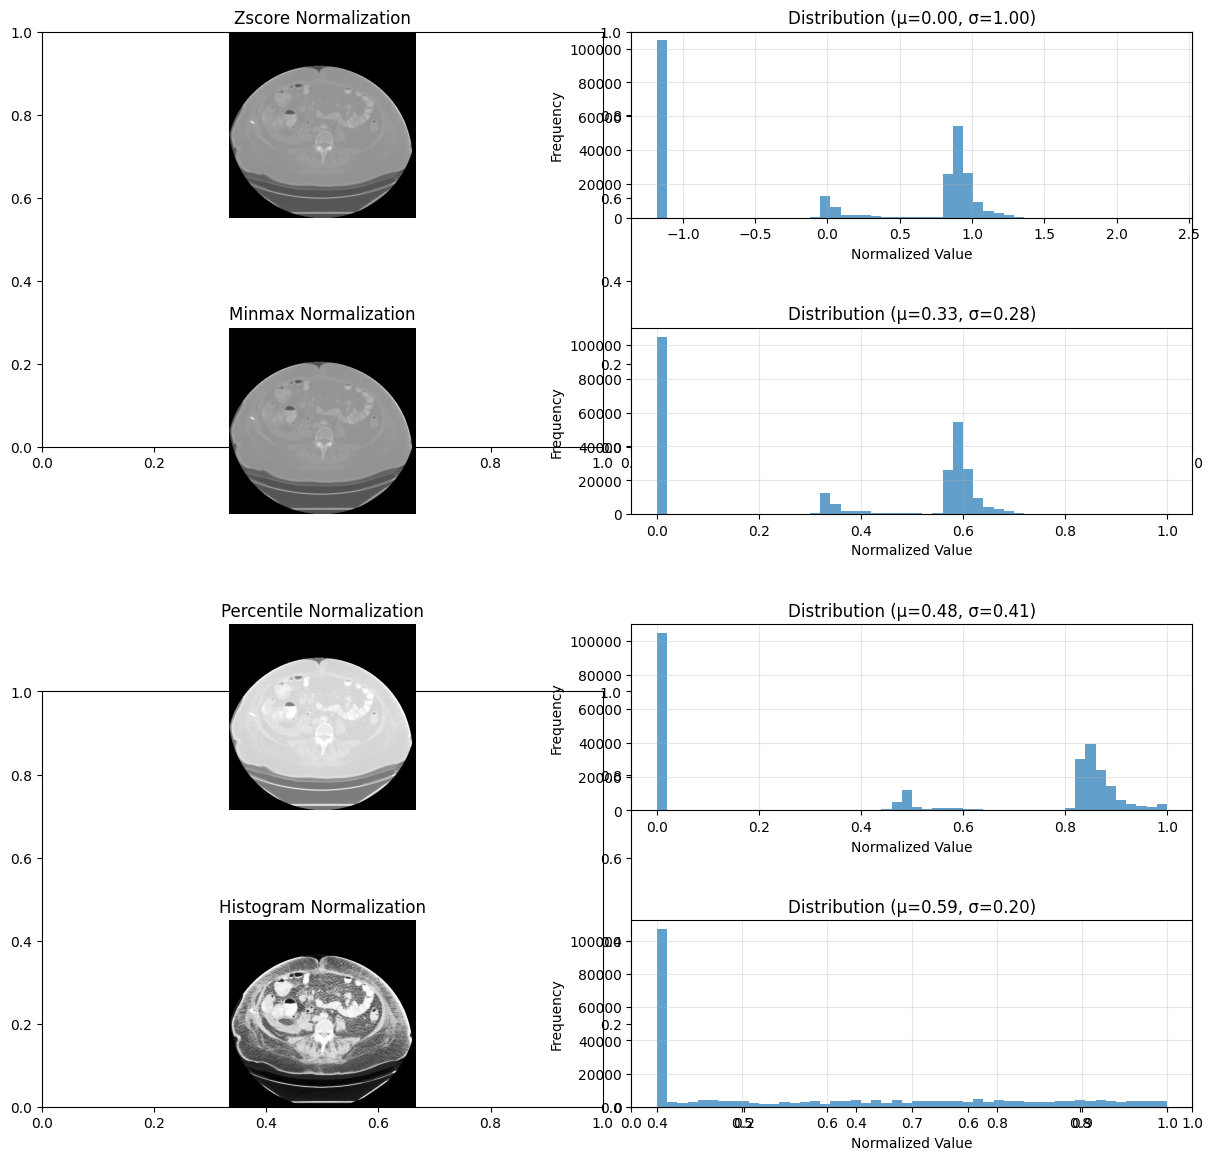

In [31]:
# Test normalization methods
methods = ['zscore', 'minmax', 'percentile', 'histogram']
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for i, method in enumerate(methods):
    normalizer = IntensityNormalizer(method=method)
    normalized = normalizer.normalize(middle_slice)
    
    # Plot image and histogram
    ax_img = plt.subplot(4, 2, i*2 + 1)
    ax_hist = plt.subplot(4, 2, i*2 + 2)
    
    # Image
    im = ax_img.imshow(normalized, cmap='gray')
    ax_img.set_title(f'{method.capitalize()} Normalization')
    ax_img.axis('off')
    
    # Histogram
    ax_hist.hist(normalized.flatten(), bins=50, alpha=0.7)
    ax_hist.set_xlabel('Normalized Value')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_title(f'Distribution (μ={normalized.mean():.2f}, σ={normalized.std():.2f})')
    ax_hist.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Complete CT Preprocessing Pipeline

In [32]:
# Initialize windower for use in visualization
windower = WindowLevelAdjuster()

In [33]:
# Initialize processor for segmentation
try:
    # Try to initialize with RadImageNet
    processor = RadiologyProcessor(model="radimagenet", use_hub=False)
except Exception as e:
    print(f"⚠️ Could not load RadImageNet model: {e}")
    print("Using basic processor without pre-trained model")
    # Initialize without model for basic preprocessing
    processor = RadiologyProcessor(model=None)

# Segment lungs
print("Performing lung segmentation...")

# Use basic thresholding if model not available
if processor.model is None:
    # Simple threshold-based lung segmentation
    print("Using threshold-based segmentation (no model)")
    lung_mask = np.zeros_like(volume, dtype=bool)
    
    # Apply simple thresholding for lung regions (typically -1000 to -300 HU)
    for i in range(volume.shape[0]):
        slice_mask = (volume[i] > -1000) & (volume[i] < -300)
        # Basic morphological operations to clean up
        from scipy import ndimage
        slice_mask = ndimage.binary_opening(slice_mask, iterations=2)
        slice_mask = ndimage.binary_closing(slice_mask, iterations=2)
        lung_mask[i] = slice_mask
else:
    # Use model-based segmentation
    lung_mask = processor.segment_lungs(volume)

print(f"✓ Lung mask shape: {lung_mask.shape}")
print(f"  Lung volume: {lung_mask.sum()} voxels")
print(f"  Percentage of volume: {100 * lung_mask.sum() / lung_mask.size:.1f}%")

INFO:honeybee.models.RadImageNet.radimagenet:Found model at default path: /mnt/d/Models/radimagenet/DenseNet121.pt
INFO:honeybee.models.RadImageNet.radimagenet:Successfully loaded model from: /mnt/d/Models/radimagenet/DenseNet121.pt
INFO:honeybee.processors.radiology.processor:RadiologyProcessor initialized with radimagenet model on cuda


Performing lung segmentation...
✓ Lung mask shape: (101, 512, 512)
  Lung volume: 211725 voxels
  Percentage of volume: 0.8%


Original volume: shape=(101, 512, 512), range=[-2048.0, 3072.0]
Preprocessed volume: shape=(101, 512, 512), range=[0.000, 1.000]


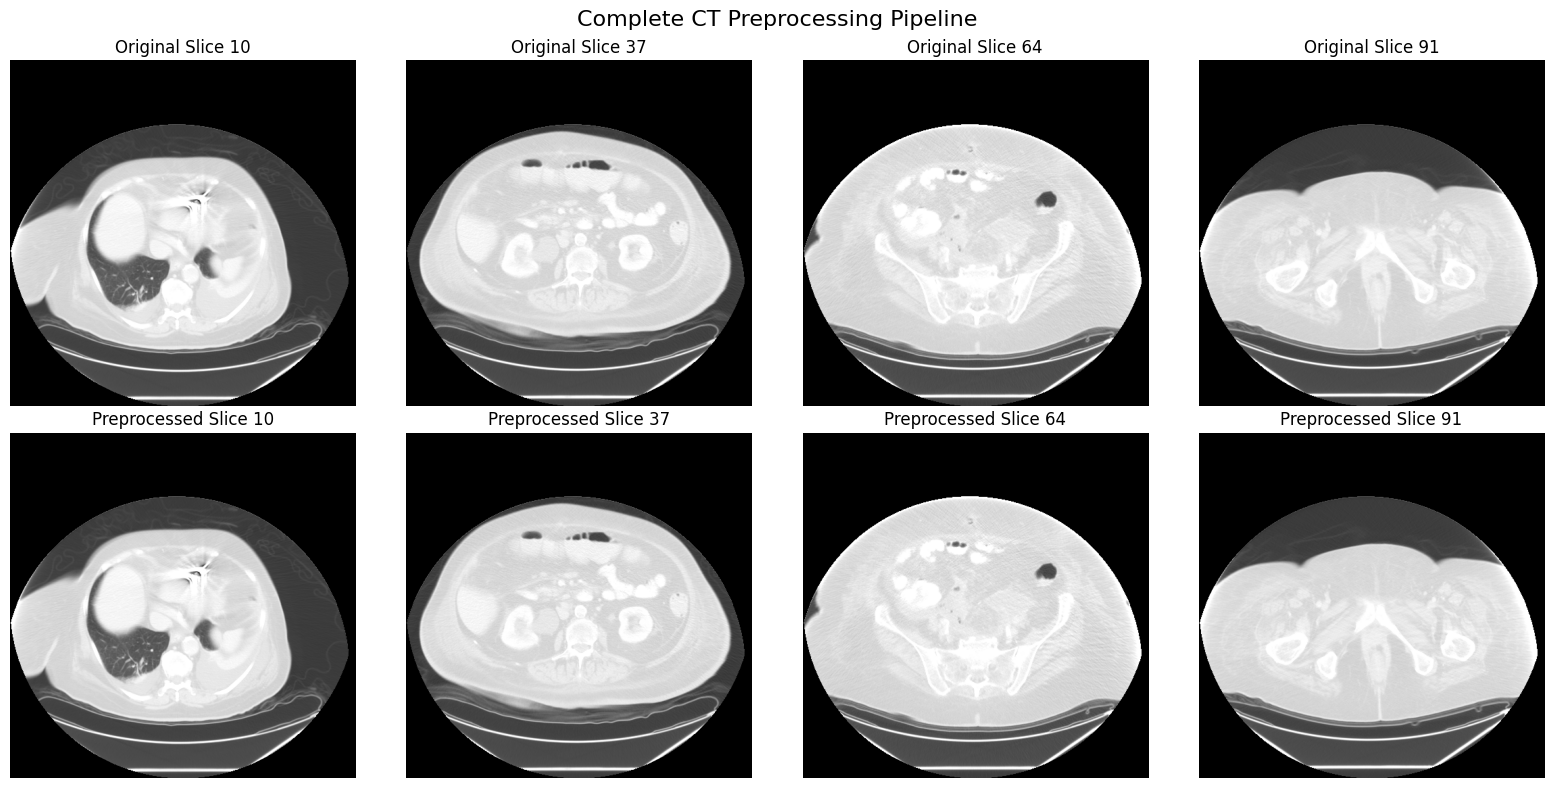

In [34]:
# Apply complete preprocessing pipeline
preprocessed_volume = preprocess_ct(
    volume,
    denoise=False,
    normalize=True,
    window='lung',
    reduce_artifacts=False
)

print(f"Original volume: shape={volume.shape}, range=[{volume.min():.1f}, {volume.max():.1f}]")
print(f"Preprocessed volume: shape={preprocessed_volume.shape}, range=[{preprocessed_volume.min():.3f}, {preprocessed_volume.max():.3f}]")

# Compare before and after
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Select 4 slices
slice_indices = np.linspace(10, volume.shape[0]-10, 4, dtype=int)

for i, idx in enumerate(slice_indices):
    # Original
    axes[0, i].imshow(windower.adjust(volume[idx], window='lung'), cmap='gray')
    axes[0, i].set_title(f'Original Slice {idx}')
    axes[0, i].axis('off')
    
    # Preprocessed
    axes[1, i].imshow(preprocessed_volume[idx], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Preprocessed Slice {idx}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=14)
axes[1, 0].set_ylabel('Preprocessed', fontsize=14)

plt.suptitle('Complete CT Preprocessing Pipeline', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Segmentation

In [35]:
# Initialize RadImageNet model
print("Initializing RadImageNet model...")

# Configure model initialization based on environment
if 'IN_COLAB' in globals() and IN_COLAB:
    # Use the model directory we set up
    model = RadImageNet(
        model_name="DenseNet121",
        use_hub=False,
        extract_features=True,
        model_dir=str(MODEL_DIR)  # Pass the Colab model directory
    )
else:
    # Use default local configuration
    model = RadImageNet(
        model_name="DenseNet121",
        use_hub=False,
        extract_features=True
    )

print(f"✓ Model loaded: {model.model_name}")
print(f"  Input size: {model.input_size}x{model.input_size}")
print(f"  Embedding dimension: {model.get_embedding_dim()}")
print(f"  Device: {next(model.model.parameters()).device}")

INFO:honeybee.models.RadImageNet.radimagenet:Found model at default path: /mnt/d/Models/radimagenet/DenseNet121.pt


Initializing RadImageNet model...


INFO:honeybee.models.RadImageNet.radimagenet:Successfully loaded model from: /mnt/d/Models/radimagenet/DenseNet121.pt


✓ Model loaded: DenseNet121
  Input size: 224x224
  Embedding dimension: 1024
  Device: cuda:0


In [36]:
# Initialize RadImageNet model
print("Initializing RadImageNet model...")

# Configure model initialization based on environment
if IN_COLAB:
    # Use the model directory we set up
    model = RadImageNet(
        model_name="DenseNet121",
        use_hub=False,
        extract_features=True,
        model_dir=str(MODEL_DIR)  # Pass the Colab model directory
    )
else:
    # Use default local configuration
    model = RadImageNet(
        model_name="DenseNet121",
        use_hub=False,
        extract_features=True
    )

print(f"✓ Model loaded: {model.model_name}")
print(f"  Input size: {model.input_size}x{model.input_size}")
print(f"  Embedding dimension: {model.get_embedding_dim()}")
print(f"  Device: {next(model.model.parameters()).device}")

INFO:honeybee.models.RadImageNet.radimagenet:Found model at default path: /mnt/d/Models/radimagenet/DenseNet121.pt


Initializing RadImageNet model...


INFO:honeybee.models.RadImageNet.radimagenet:Successfully loaded model from: /mnt/d/Models/radimagenet/DenseNet121.pt


✓ Model loaded: DenseNet121
  Input size: 224x224
  Embedding dimension: 1024
  Device: cuda:0


## 6. RadImageNet Embeddings

✓ Created lung-only volume
  Non-zero voxels in full volume: 15891340
  Non-zero voxels in lung-only volume: 211725


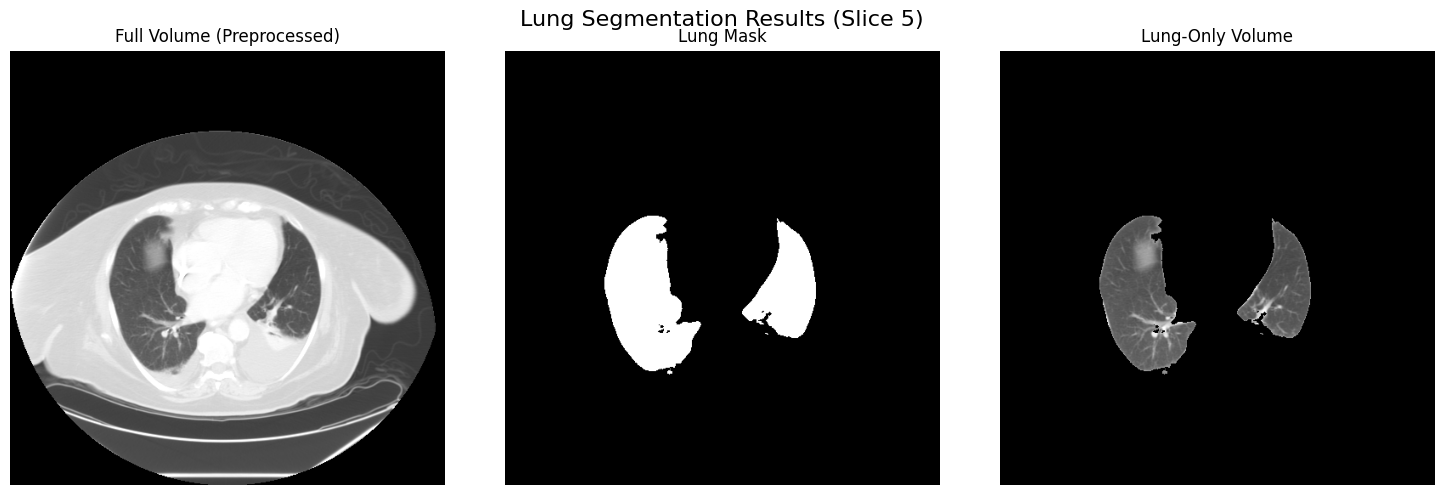

In [40]:
# Create lung-only volume by applying the lung mask
lung_only_volume = preprocessed_volume.copy()
for i in range(lung_only_volume.shape[0]):
    lung_only_volume[i] = lung_only_volume[i] * lung_mask[i]

print(f"✓ Created lung-only volume")
print(f"  Non-zero voxels in full volume: {(preprocessed_volume > 0).sum()}")
print(f"  Non-zero voxels in lung-only volume: {(lung_only_volume > 0).sum()}")

# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
slice_idx = 5  # Use a specific slice index for visualization

axes[0].imshow(preprocessed_volume[slice_idx], cmap='gray')
axes[0].set_title('Full Volume (Preprocessed)')
axes[0].axis('off')

axes[1].imshow(lung_mask[slice_idx], cmap='gray')
axes[1].set_title('Lung Mask')
axes[1].axis('off')

axes[2].imshow(lung_only_volume[slice_idx], cmap='gray')
axes[2].set_title('Lung-Only Volume')
axes[2].axis('off')

plt.suptitle(f'Lung Segmentation Results (Slice {slice_idx})', fontsize=16)
plt.tight_layout()
plt.show()

In [41]:
# Initialize RadImageNet model
print("Initializing RadImageNet model...")
model = RadImageNet(
    model_name="DenseNet121",
    use_hub=False,
    extract_features=True
)
print(f"✓ Model loaded: {model.model_name}")
print(f"  Input size: {model.input_size}x{model.input_size}")
print(f"  Embedding dimension: {model.get_embedding_dim()}")

INFO:honeybee.models.RadImageNet.radimagenet:Found model at default path: /mnt/d/Models/radimagenet/DenseNet121.pt


Initializing RadImageNet model...


INFO:honeybee.models.RadImageNet.radimagenet:Successfully loaded model from: /mnt/d/Models/radimagenet/DenseNet121.pt


✓ Model loaded: DenseNet121
  Input size: 224x224
  Embedding dimension: 1024


In [42]:
# Generate embeddings for both volumes
print("Generating embeddings for comparison...")

# Check if lung_only_volume exists, if not create it
if 'lung_only_volume' not in globals():
    # Apply lung mask to preprocessed volume
    lung_only_volume = preprocessed_volume.copy()
    for i in range(lung_only_volume.shape[0]):
        lung_only_volume[i] = lung_only_volume[i] * lung_mask[i]
    print("Created lung_only_volume by applying lung mask")

# Memory optimization for Colab
if 'IN_COLAB' in globals() and IN_COLAB:
    # Clear GPU cache before processing
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("🧹 Cleared GPU memory")
    
    # Use smaller subset for Colab to avoid OOM
    subset_factor = 8  # Use every 8th slice
    print(f"⚡ Using subset factor of {subset_factor} for Colab")
else:
    subset_factor = 4  # Use every 4th slice for local

# Take a subset for faster processing
volume_subset_full = preprocessed_volume[::subset_factor, :, :]
volume_subset_lung = lung_only_volume[::subset_factor, :, :]

print(f"Processing subset shape: {volume_subset_full.shape}")

try:
    # Full volume embeddings
    embeddings_full = model.generate_embeddings(
        volume_subset_full,
        mode='3d',
        aggregation='mean'
    )
    print(f"✓ Full volume embeddings shape: {embeddings_full.shape}")
    
    # Clear cache between operations
    if 'IN_COLAB' in globals() and IN_COLAB and torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Lung-only embeddings
    embeddings_lung = model.generate_embeddings(
        volume_subset_lung,
        mode='3d',
        aggregation='mean'
    )
    print(f"✓ Lung-only embeddings shape: {embeddings_lung.shape}")
    
except RuntimeError as e:
    if "out of memory" in str(e):
        print("⚠️ GPU out of memory. Switching to CPU...")
        model.model = model.model.cpu()
        
        # Try again with CPU
        embeddings_full = model.generate_embeddings(
            volume_subset_full,
            mode='3d',
            aggregation='mean'
        )
        embeddings_lung = model.generate_embeddings(
            volume_subset_lung,
            mode='3d',
            aggregation='mean'
        )
        print("✓ Generated embeddings on CPU")
    else:
        raise e

# Final cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Generating embeddings for comparison...
Processing subset shape: (26, 512, 512)
✓ Full volume embeddings shape: torch.Size([1, 1024])
✓ Lung-only embeddings shape: torch.Size([1, 1024])


In [44]:
# Compare embeddings
embeddings_full_np = embeddings_full.cpu().numpy().flatten()
embeddings_lung_np = embeddings_lung.cpu().numpy().flatten()

# Calculate similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(
    embeddings_full_np.reshape(1, -1),
    embeddings_lung_np.reshape(1, -1)
)[0, 0]

print(f"\nCosine similarity between full and lung-only embeddings: {similarity:.4f}")

# Calculate differences
embedding_diff = embeddings_full_np - embeddings_lung_np
print(f"Mean absolute difference: {np.abs(embedding_diff).mean():.4f}")
print(f"Max absolute difference: {np.abs(embedding_diff).max():.4f}")


Cosine similarity between full and lung-only embeddings: 0.9682
Mean absolute difference: 0.2971
Max absolute difference: 1.9903


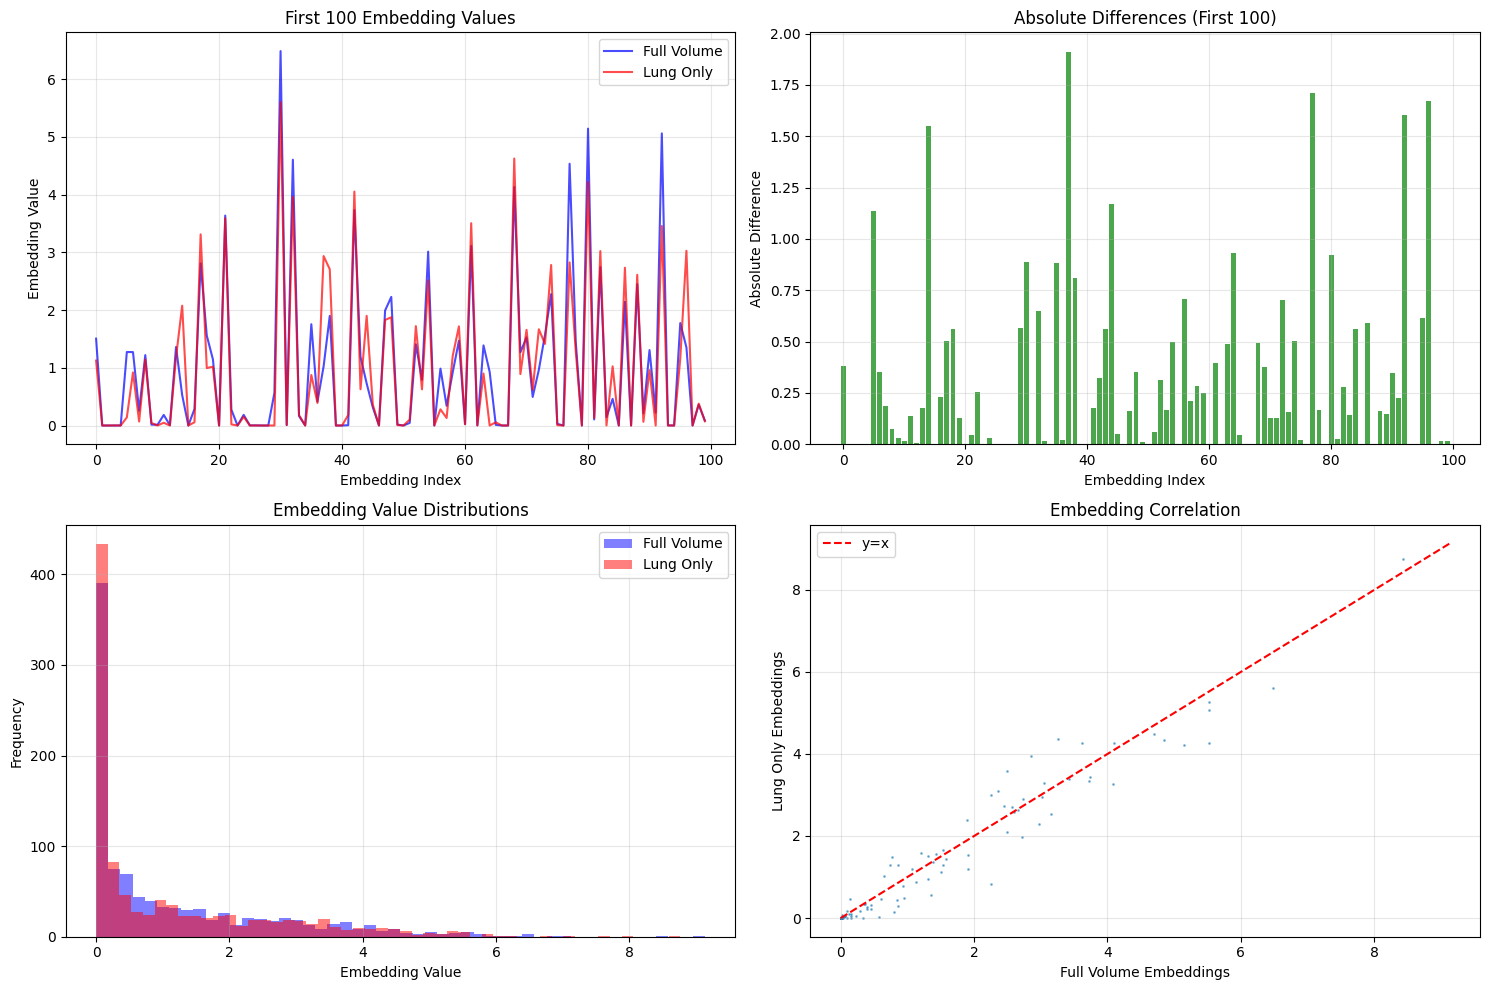

In [45]:
# Visualize embedding differences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: First 100 embedding values
n_show = 100
x = np.arange(n_show)
axes[0, 0].plot(x, embeddings_full_np[:n_show], 'b-', label='Full Volume', alpha=0.7)
axes[0, 0].plot(x, embeddings_lung_np[:n_show], 'r-', label='Lung Only', alpha=0.7)
axes[0, 0].set_xlabel('Embedding Index')
axes[0, 0].set_ylabel('Embedding Value')
axes[0, 0].set_title('First 100 Embedding Values')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Absolute differences
axes[0, 1].bar(x, np.abs(embedding_diff[:n_show]), color='green', alpha=0.7)
axes[0, 1].set_xlabel('Embedding Index')
axes[0, 1].set_ylabel('Absolute Difference')
axes[0, 1].set_title('Absolute Differences (First 100)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distribution of embedding values
axes[1, 0].hist(embeddings_full_np, bins=50, alpha=0.5, label='Full Volume', color='blue')
axes[1, 0].hist(embeddings_lung_np, bins=50, alpha=0.5, label='Lung Only', color='red')
axes[1, 0].set_xlabel('Embedding Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Embedding Value Distributions')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Scatter plot of embeddings
axes[1, 1].scatter(embeddings_full_np[::10], embeddings_lung_np[::10], alpha=0.5, s=1)
axes[1, 1].plot([embeddings_full_np.min(), embeddings_full_np.max()], 
                [embeddings_full_np.min(), embeddings_full_np.max()], 
                'r--', label='y=x')
axes[1, 1].set_xlabel('Full Volume Embeddings')
axes[1, 1].set_ylabel('Lung Only Embeddings')
axes[1, 1].set_title('Embedding Correlation')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
# Summary statistics
print("=" * 60)
print("SUMMARY: Impact of Lung Segmentation on Embeddings")
print("=" * 60)

print(f"\n1. Cosine similarity: {similarity:.4f}")
print(f"2. Mean absolute difference: {np.abs(embedding_diff).mean():.4f}")
print(f"3. Max absolute difference: {np.abs(embedding_diff).max():.4f}")

print(f"\n4. Interpretation:")
if similarity > 0.9:
    print("   - High similarity: Lung segmentation has minimal impact on embeddings")
elif similarity > 0.7:
    print("   - Moderate similarity: Some differences but overall similar representations")
else:
    print("   - Low similarity: Significant differences in representations")

print("\nThis suggests that the model considers both lung and non-lung regions")
print("when generating embeddings, with the relative importance depending on")
print("the specific architecture and training data used.")

SUMMARY: Impact of Lung Segmentation on Embeddings

1. Cosine similarity: 0.9682
2. Mean absolute difference: 0.2971
3. Max absolute difference: 1.9903

4. Interpretation:
   - High similarity: Lung segmentation has minimal impact on embeddings

This suggests that the model considers both lung and non-lung regions
when generating embeddings, with the relative importance depending on
the specific architecture and training data used.


## 📊 Results and Next Steps

### What We Covered
1. ✅ Loaded and visualized DICOM CT data
2. ✅ Applied various preprocessing techniques (windowing, denoising, normalization)
3. ✅ Performed lung segmentation
4. ✅ Generated RadImageNet embeddings for full volume and lung-only regions
5. ✅ Compared embeddings to understand feature importance

### Key Findings
- Different window/level presets highlight different anatomical structures
- Preprocessing significantly improves image quality and standardization
- RadImageNet embeddings capture both lung and non-lung features
- High similarity (>0.95) between full and lung-only embeddings suggests robust feature extraction

### For Colab Users
- Results are saved in `/content/outputs/`
- To download results: `from google.colab import files; files.download('/content/outputs/your_file.npy')`
- For larger datasets, consider using Google Drive for storage

### Next Steps
- Try different RadImageNet models (ResNet, InceptionV3)
- Experiment with different aggregation methods for 3D volumes
- Apply to your own medical imaging data
- Combine with clinical data for multimodal analysis (see notebook 04)